##### 2020 George Mihaila.

# Find new sentiments in text data


<td>
    <a target="_blank" href="https://jupyterlab.hpc.unt.edu/"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run on Talon</a>
</td>
<td>
  <a target="_blank" href="https://github.com/gmihaila/unt_hpc/blob/master/workshops/march_3_2019/README.md"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</br>

The main purpose of this tutorial is to target a particular Natural Language Processing (NLP) problem, in this case Sentiment Analysis, and use GPUs for great speedup.

Walkthoughs:

### Dataset used:
* [IMDB moview reviews sentiment dataset](http://ai.stanford.edu/%7Eamaas/data/sentiment/): This is a dataset for binary sentiment classification containing a set of **25,000** highly polar movie reviews for training, and **25,000** for testing. For this tutorial we will combine the train and test data for a total of **50,000 movies reviews** text data and their negative/positive labels.


### Content:

 * Train custom word embeddings using a small Neural Network.
 * Use Lime to explain model predictions.
 * Use the embedding model to create review embeddings.
 * Use GPU to perform kmeans clustering on all 50,000 movies reviews.
 * Find the best splitting K using the Elbow method and Silhouette score.
 * Use k=2 on kmeans and plot the sentiments on both predicted clusters and true labels.
 * Observe the overlap between the predcited labels and true labels and asociate labels to clusters. Visualize the clusters.
 * Try to find a third sentiment using k=3. Observe the overlab between predicted labels and true labels. Visualize the clusters.
 * Repeat previous experiments using different k and observe predicitons overlp with true labels. Visualize the clusters.
 * Visualize samples of text that are predicted with various sentiments.

## NLP - Fine-grained Sentiment Analysis

For most cases sentiment classifiers are used in binary classification (just positive or negative sentiment). That is because fine-grained sentiment classification is a significantly more challenging task! 

The typical breakdown of fine-grained sentiment uses five discrete classes, as shown below. As one might imagine, models very easily err on either side of the strong/weak sentiment intensities thanks to the wonderful subtleties of human language.

![alt text](https://miro.medium.com/max/705/1*ug8kyqUlnqEuo3LhHfNypg.png)

Binary class labels may be sufficient for studying large-scale positive/negative sentiment trends in text data such as Tweets, product reviews or customer feedback, but they do have their limitations. 

When performing information extraction with comparative expressions, for example: 
 * “This OnePlus model X is so much better than Samsung model X.” 
  * a fine-grained analysis can provide more precise results to an automated system that prioritizes addressing customer complaints. 

 * “The location was truly disgusting ... but the people there were glorious.” 
  * dual-polarity sentences can confuse binary sentiment classifiers, leading to incorrect class predictions.

[source](https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4)



## Installs

* [Sentence-Transformers](https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=scfLT2i0MLyD): wrapper around Hugging Face [transformers](https://github.com/huggingface/transformers) library and built for document embedding using state of the art language models like BERT or XLNET.

## Dataset

* **data/imdb_reviews_50k.csv** contains all movie revies and their sentiments:
    
* **data/movies_reviews_embeddings_part1.npy** and **data/movies_reviews_embeddings_part2.npy** contain BERT Embeddings of all `50,000` movie revies. They are saved in numpy format binary. 
   They are the output of running `SentenceTransformer` on all the text using `bert-base-nli-mean-tokens` pretrained model.

## Imports

In [2]:
import os
# avoid using GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = ''
import torch
## Load TF 2.0
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords 
import nltk
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from lime.lime_text import LimeTextExplainer


nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

ID_SENTIMENT = {0:'Negative',
                1:'Positive'}

PRETRAINED_MODEL = 'bert-base-nli-stsb-mean-tokens'

[nltk_data] Downloading package stopwords to /home/gm0234/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gm0234/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/cm/shared/utils/PYTHON/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Functions

In [4]:
def plt_history(history_dict, 
                acc_key='accuracy', val_acc_key='val_accuracy', 
                loss_key='loss', val_loss_key='val_loss'):
  acc = history_dict[acc_key]
  val_acc = history_dict[val_acc_key]
  loss = history_dict[loss_key]
  val_loss = history_dict[val_loss_key]
  epochs = range(1, len(acc) + 1)
  plt.subplot(1, 2, 1)
  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)


  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)
  fig = plt.gcf()
  fig.set_size_inches(15, 5)
  plt.show()
  return


def predictions_overlap(model_predicitons, true_predicitons, label_decoder):
  """Find overlap between predicted labels that aren't associated with any actual classes
  and actual classes.

  """
  labels = list(set(model_predicitons))
  print("Found labels: %s\n" % labels)
  ## dicitonary with predicitons counts clusters
  predictions = {label:[] for label in labels}
  for true_label, pred_label in zip(true_predicitons, model_predicitons):
    predictions[pred_label].append(true_label)
  # data frame
  matching_df = pd.DataFrame()
  matching_df['labels'] = labels
  matching_df['cluster_match'] = ["  ".join([str(label_decoder[cluster])+":"+str(count) for cluster, count in Counter(predictions[label]).most_common()]) for label in labels]
  return matching_df


def clusters_words_plot(texts, labels, n_sentiments, pos_tag, top_clip=0, low_clip=20, stop_words=None, magnify=2):
  # low_clip and top_clip are clips of the most frequent words to show
  # pos_tag in ['VB', 'NN']
  labels_texts = {n:[] for n in range(n_sentiments)}
  for text, label in zip(texts, labels):
    labels_texts[label].append(text)
  for sentiment in range(n_sentiments):
    # fit tokenizer on texts
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts=labels_texts[sentiment])
    top_words = list(tokenizer.word_index.keys())
    if pos_tag is not None: 
      top_words = nltk.pos_tag(tokens=top_words)
      top_words = [val[0] for val in top_words if val[1]==pos_tag]
    if stop_words is not None: top_words=[word for word in top_words if word not in stop_words]
    # temporary Data Frame
    tmp_df = pd.DataFrame()
    tmp_df['words'] = top_words[top_clip:low_clip]
    tmp_df['count'] = [tokenizer.word_counts[word] for word in top_words[top_clip:low_clip]]
    # plot
    ax = sns.barplot(x='words', y='count', data=tmp_df)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large')
    fig = plt.gcf()
    ax.set_title('Words Counts Sentimen %s'%sentiment)
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
  return


def show_samples(target_predicitons_class, texts, predicitons, trues, trues_id_sentiment,
                 predictions_id_sentiment, n_samples):
  samples_texts = []
  samples_labels = []

  while len(samples_texts) < n_samples:
    pick = np.random.randint(low=0, high=(len(trues)-1))
    if predicitons[pick] == target_predicitons_class:
      samples_texts.append(texts[pick])
      samples_labels.append(trues[pick])

  samples_df = pd.DataFrame()
  samples_df['Text'] = samples_texts
  samples_df['Label Sentiment'] = [trues_id_sentiment[label] for label in samples_labels]
  samples_df['Prediction Sentiment'] = [predictions_id_sentiment[target_predicitons_class] for _ in samples_labels]
  return samples_df

# Data Prep

## Read CSV

In [5]:
# read reviews from csv file
review_sentiments_df = pd.read_csv('../data/imdb_reviews_50k.csv')
# get reviews and sentiments
reviews_texts, reviews_sentiments = review_sentiments_df['review'].values, review_sentiments_df['sentiment'].values
# print first 2 examples
review_sentiments_df.head(n=2)

,review,sentiment
0,"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",0
1,"I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else. I cant recommend this film at all.",0


## BERT Embeddings

In [6]:
# load for future predicitons
embedding_model = SentenceTransformer(model_name_or_path='bert-base-nli-mean-tokens',
                                    device=torch.device('cpu'))
# load embeddings for all reviews
reviews_embeddings_part1 = np.load('../data/movies_reviews_embeddings_part1.npy')
reviews_embeddings_part2 = np.load('../data/movies_reviews_embeddings_part2.npy')
# concatenate parts
reviews_embeddings = np.concatenate((reviews_embeddings_part1, reviews_embeddings_part2))

print('Bert Embeddings Loaded: ', reviews_embeddings.shape)

Bert Embeddings Loaded:  (50000, 768)


# Simple Neural Network

## Config

In [7]:
EMBEDDING_SIZE = 768
BUFFER_SIZE = 1000
BATCH = 500
EPOCHS = 20

## Prep Data

In [8]:
# split train 80% - test 20% 
embeddings_train, embeddings_test, sentiments_train, sentiments_test = train_test_split(reviews_embeddings, reviews_sentiments, train_size=0.8, shuffle=True, random_state=20)
# split train into validation 10%
embeddings_train, embeddings_valid, sentiments_train, sentiments_valid = train_test_split(embeddings_train, sentiments_train, train_size=0.9, shuffle=True, random_state=20)
# shape (number of examples X sequence length)
print('Train shape:     ', embeddings_train.shape)
print('Validation shape:', embeddings_valid.shape)
print('Test shape:      ', embeddings_test.shape)

Train shape:      (36000, 768)
Validation shape: (4000, 768)
Test shape:       (10000, 768)


## Data Generators

In [9]:
# train generator
train_genrator = tf.data.Dataset.from_tensor_slices((embeddings_train, sentiments_train))
# batching generator and shuffle
train_batches = train_genrator.batch(BATCH).shuffle(BUFFER_SIZE)
# increase speed by overlaping the preprocessing and model execution of a training step
train_batches = train_batches.prefetch(tf.data.experimental.AUTOTUNE)

# validation generator
valid_genrator = tf.data.Dataset.from_tensor_slices((embeddings_valid, sentiments_valid))
# batching generator
valid_batches = valid_genrator.batch(BATCH)
# increase speed by overlaping the preprocessing and model execution of a training step
valid_genrator = valid_genrator.prefetch(tf.data.experimental.AUTOTUNE)

## Modeling

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 16)                12304     
_________________________________________________________________
prediction (Dense)           (None, 1)                 17        
Total params: 12,321
Trainable params: 12,321
Non-trainable params: 0
_________________________________________________________________
Train for 72 steps, validate for 8 steps
Epoch 1/20
72/72 [==============================] - 1s 12ms/step - loss: 0.4532 - accuracy: 0.7851 - val_loss: 0.4230 - val_accuracy: 0.7995
Epoch 2/20
72/72 [==============================] - 0s 6ms/step - loss: 0.4132 - accuracy: 0.8079 - val_loss: 0.4220 - val_accuracy: 0.8073
Epoch 3/20
72/72 [==============================] - 1s 7ms/step - loss: 0.4030 - accuracy: 0.8131 - val_loss: 0.3962 - val_accuracy: 0.8200
Epoch 4/20
72/72 [==============================] - 

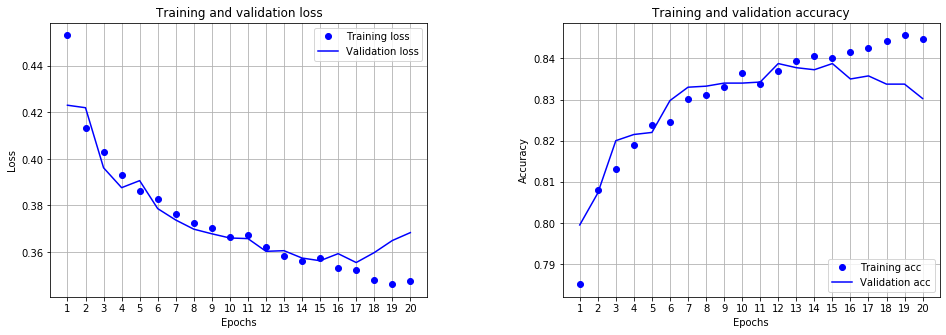

In [10]:
# build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16, input_shape=(EMBEDDING_SIZE,), activation='elu', name='hidden'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='prediction'))
# print overview
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# train and keep track of history
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=valid_batches,
                    verbose=1)
# plot training curves
plt_history(history_dict=history.history)

## Evaluation

In [11]:
# get model predicitons
sentiments_predicitons = model.predict_classes(embeddings_test)
# print evaluation report
print(classification_report(y_true=sentiments_test, y_pred=sentiments_predicitons))

              precision    recall  f1-score   support

           0       0.88      0.76      0.81      4948
           1       0.79      0.90      0.84      5052

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



## Explain Model

In [10]:
example_sample = 'Movie was great! I hate it!'

# explain model prediciton
def classifier_dn(texts):
  '''Takes as input list of stirngs.
  Outputs numpy array of porbabilities
  '''
  probab = []
  encodings_texts = embedding_model.encode(sentences=texts, 
                                          batch_size=500, 
                                          show_progress_bar=True)
  encodings_texts = np.array(encodings_texts)
  for encoding_text in encodings_texts:
    preds = model(encoding_text.reshape(1,768))[0][0]
    probab.append([(1-preds), preds])
  return np.array(probab)

# create explainer
explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(example_sample,  classifier_dn, num_features=EMBEDDING_SIZE)
# output to cell
exp.show_in_notebook(text=True)

/home/gm0234/.local/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
Batches: 100%|██████████| 10/10 [01:53<00:00, 11.37s/it]


# Run Best k-means model

In [12]:
# pick best k based on previous experiments
best_k = 2
# build model using specific k
kmean_model = KMeans(n_clusters=best_k)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
best_kmeans_labels = kmean_model.labels_

## PCA Visualize

In [13]:
def pca_reduction(features, labels_values, n_components, random_state=20, 
                  label_decoder=None, title='PCA Plot', magnify=2):
  pca_cuml = PCA(n_components=n_components,
                   random_state=random_state)
  reduced_features = pca_cuml.fit_transform(features)

  # plot
  if (n_components==2) and (labels_values is not None):
    # create data frame
    reduced_features_df = pd.DataFrame()
    reduced_features_df['x'] = [float(value) for value in reduced_features[:,0]]
    reduced_features_df['y'] = [float(value) for value in reduced_features[:,1]]
    if label_decoder is not None:
      reduced_features_df['clusters'] = [label_decoder[int(value)] for value in labels_values]
    else:
      reduced_features_df['clusters'] = [int(value) for value in labels_values]
    #plot data with seaborn
    cluster_plot = sns.lmplot(data=reduced_features_df, x='x', y='y', hue='clusters', fit_reg=False, legend=True, legend_out=True)
    plt.title(title)
    fig = plt.gcf()
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
    cluster_plot.savefig("pca_plot.png")
  return reduced_features

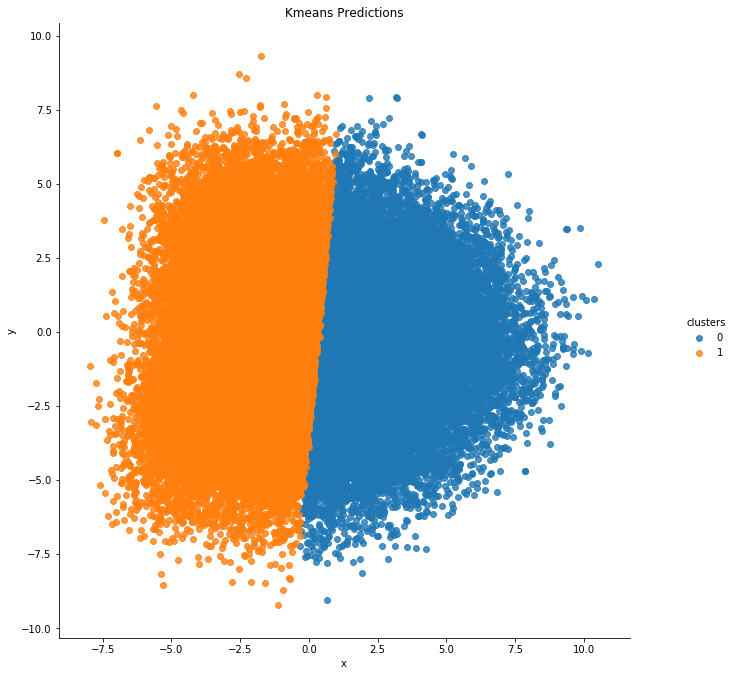

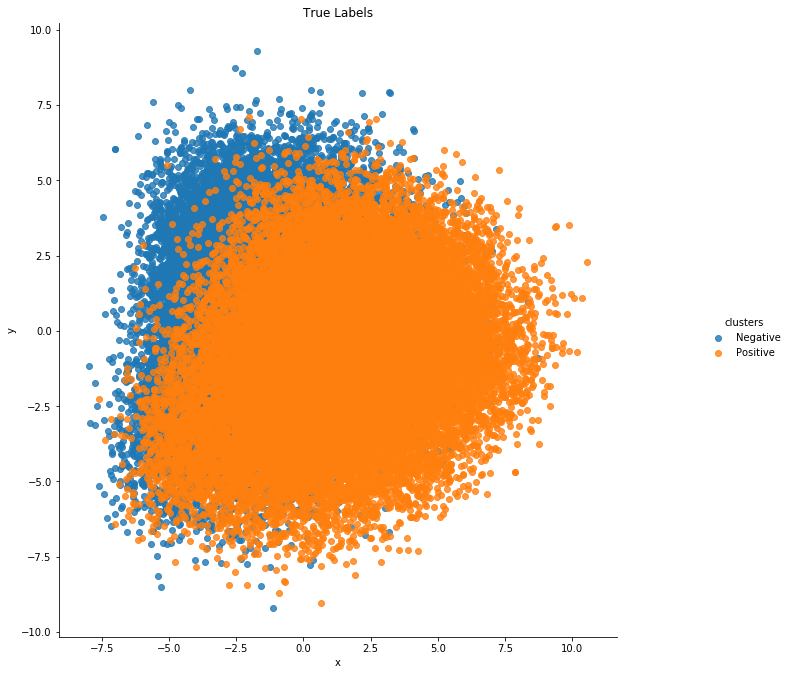



Found labels: [0, 1]



,labels,cluster_match
0,0,Positive:16533 Negative:5095
1,1,Negative:19905 Positive:8467


In [14]:
reduced_features = pca_reduction(features=reviews_embeddings, 
                                 labels_values=best_kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=None,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=reviews_embeddings, 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')

print('\n')
matching_df = predictions_overlap(model_predicitons=best_kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

# K Means Sentiments

## k=3 sentiments

In [15]:
k_sentiments = 3
# build model using specific k
kmean_model = KMeans(n_clusters=k_sentiments)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
kmeans_labels = kmean_model.labels_

### Find Labels

In [16]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2]



,labels,cluster_match
0,0,Positive:7653 Negative:7310
1,1,Negative:14630 Positive:3824
2,2,Positive:13523 Negative:3060


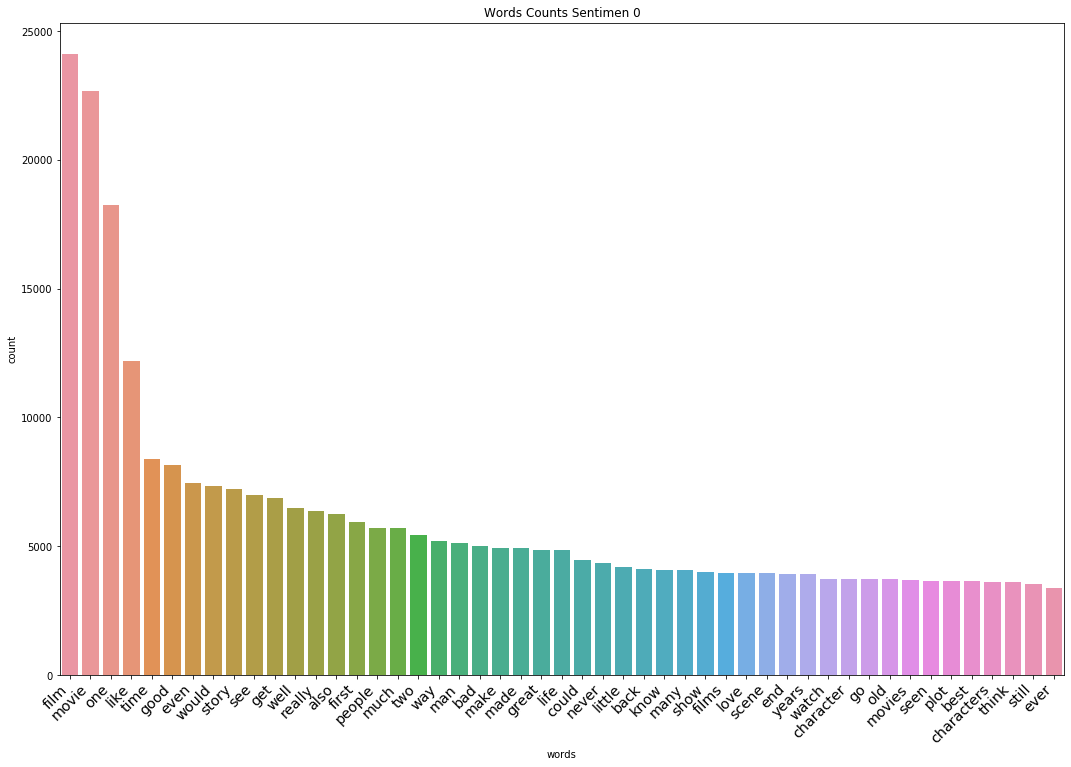

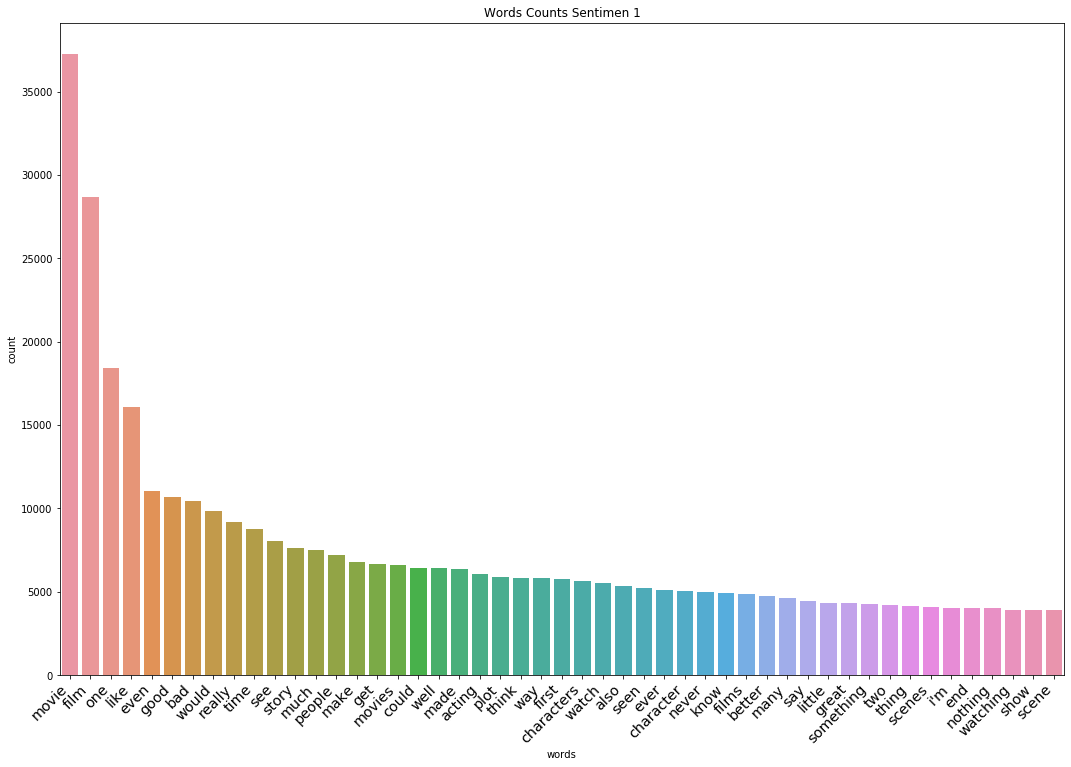

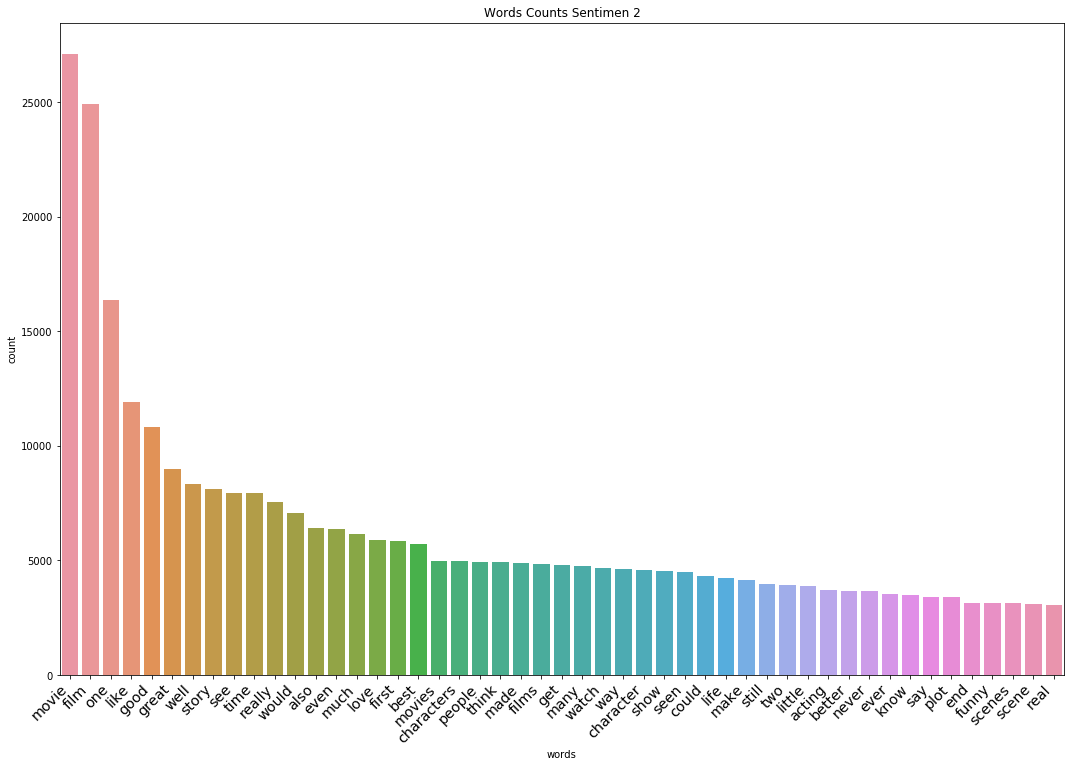

In [17]:
clusters_words_plot(texts=reviews_texts, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

### Visualize

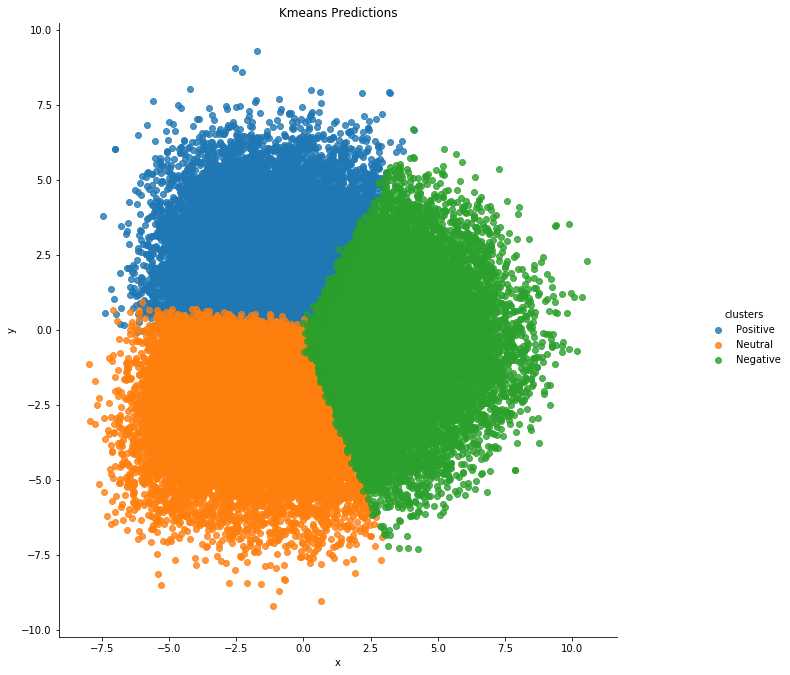

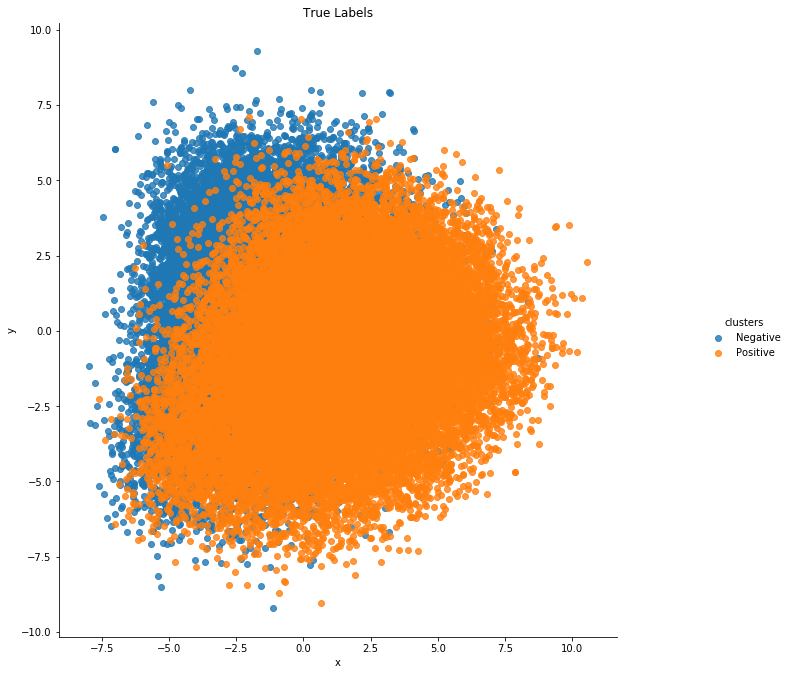

In [18]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative'}

reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [19]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=reviews_texts,
                          trues=reviews_sentiments, 
                          trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                          predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

,Text,Label Sentiment,Prediction Sentiment
0,"A ghost story on a typical Turkish high school with nice sound and visual effects. Taylan biraderler(taylan brothers) had made their first shots on a tv-show a couple of years ago, as far as i know. That was kind of a Turkish X-Files, they had very nice stories but lacked on visual effects. This time it seems they had what they needed and used them well. This movie will make you laugh that's for sure, and as well it might have you scared. It has a nice plot and some young, bright actors in it. If you are a high school student in Turkey you will find so many things about you here. There are many clues in the movie about its story and ending, some you understand at the moment, some will make sense afterwords, the dialogs were written very cleverly. So these make the movie one of the best Turk movies made in the last years. Do not forget, this movie is the first of its kind in the Turkish film industry.",Positive,Neutral
1,"Dr. Ben McKenna (James Stewart) and Jo McKenna (Doris Day) travel to Morocco for a holiday where they meet a mysterious man named Louis Bernard (Daniel Gélin) on a bus.The next day this man is murdered, but before he dies he tells Ben a secret; an assassination will take place in London.The crooks kidnap the couple's son Hank (Christopher Olsen) making sure Ben won't reveal their plan to anybody.Alfred Hitchcock's The Man Who Knew Too Much (1956) is a very intense thriller.The acting is superb as it always is in Hitchcok's films.James Stewart is marvelous.Doris Day is a delightful person and actress and she gets to show her singing talents as well.The song Que Sera, Sera has an important part in the movie.This movie is a movie of many classic scenes.In the final scenes at the Albert Hall, done without dialogue, you can barely blink your eyes.This movie is fifty years old now.Time hasn't decreased its power in any way.",Positive,Neutral
2,"Little Vera is the story of a Russian teenager, her family, and her attempts to find meaning and value in a life sliding increasingly into decay. In her search for meaning, she falls in love with a more intellectual and rebellious Sergei, whose hatred for her deeply flawed parents quickly spirals out of control.<br /><br />Little Vera is shocking and disturbing in nearly every way. The drinking of the father, the enabling and lack of understanding of the mother, the casual lies and misdirection of the brother, and Vera herself forgiving them all their flaws are all shocking and slightly disturbing to watch. However, the raw honesty of the film somehow manages to become even more shocking than the plot or characters. Set in cramped spaces and vast urban decay, Little Vera presented a vastly different view of Soviet life than had ever been seen before. In fact, Little Vera is a portrait of the collapse of Soviet society painted in shades of pain, desperation, and rust. It is the implosion of a family set against the implosion of an entire social order.<br /><br />Although painful and desperately unsatisfying, the film itself is definitely worth seeing, if only to understand the feelings and cultures still reshaping Russia today.",Positive,Neutral


## k=4 sentiments

In [20]:
k_sentiments = 4
# build model using specific k
kmean_model = KMeans(n_clusters=k_sentiments)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
kmeans_labels = kmean_model.labels_

### Find Labels

In [21]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2, 3]



,labels,cluster_match
0,0,Positive:6652 Negative:4081
1,1,Negative:13362 Positive:3156
2,2,Positive:10696 Negative:2208
3,3,Negative:5349 Positive:4496


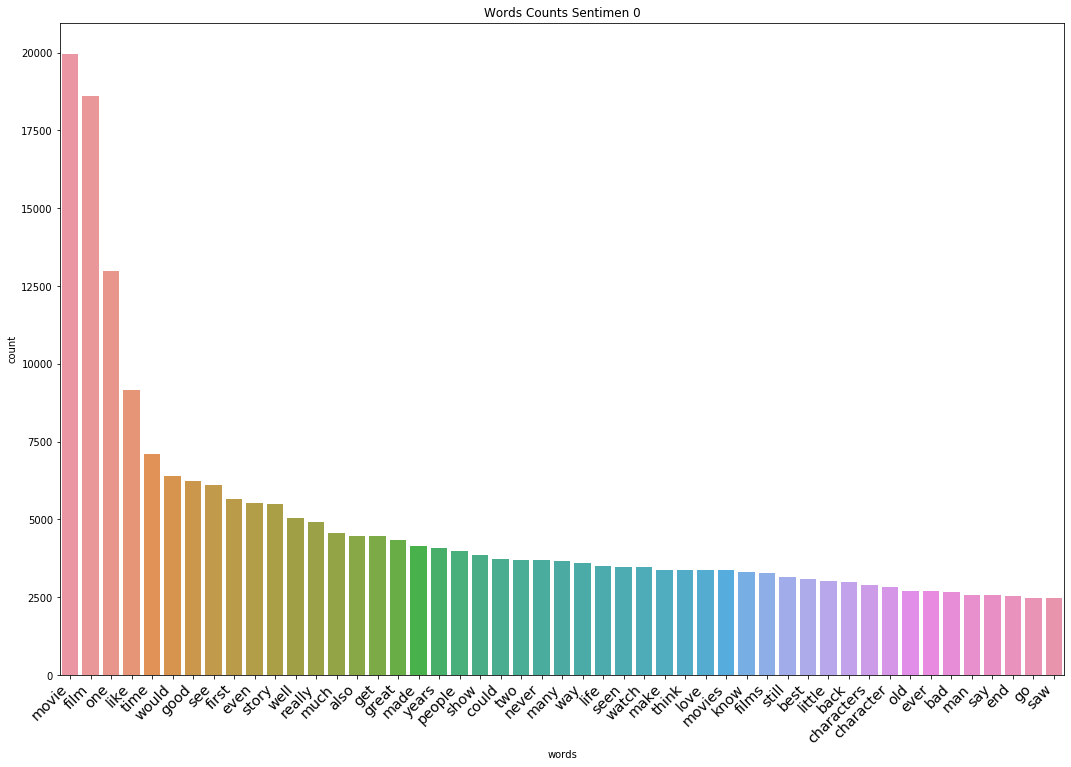

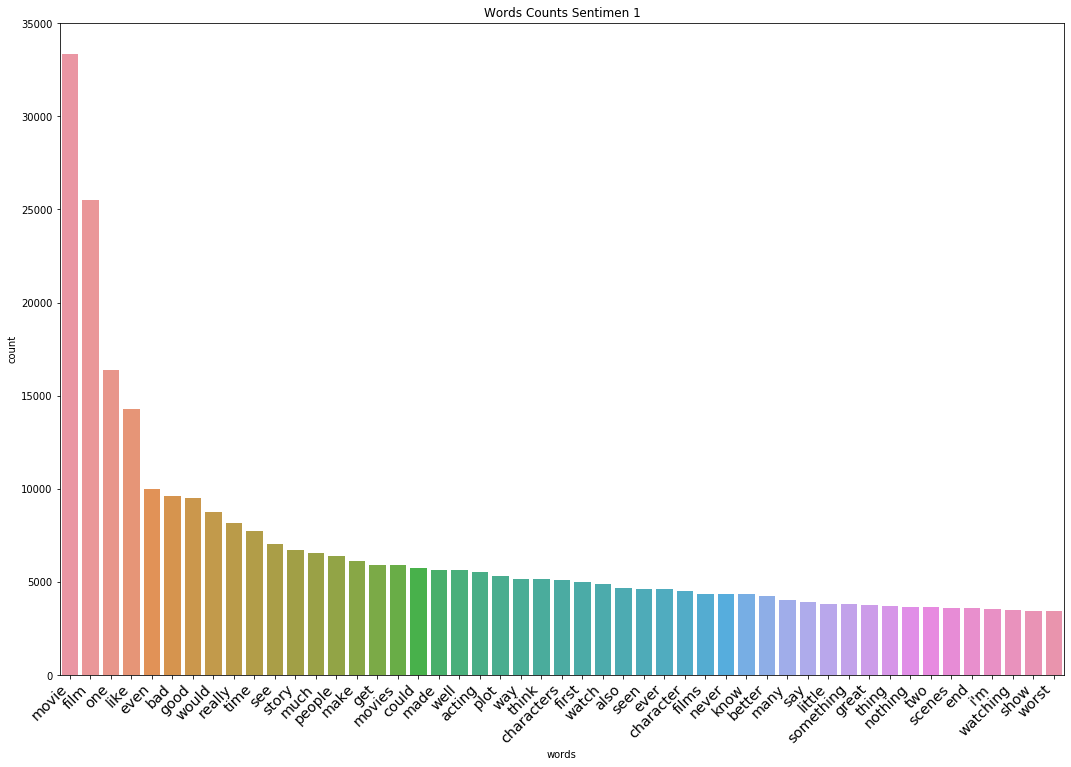

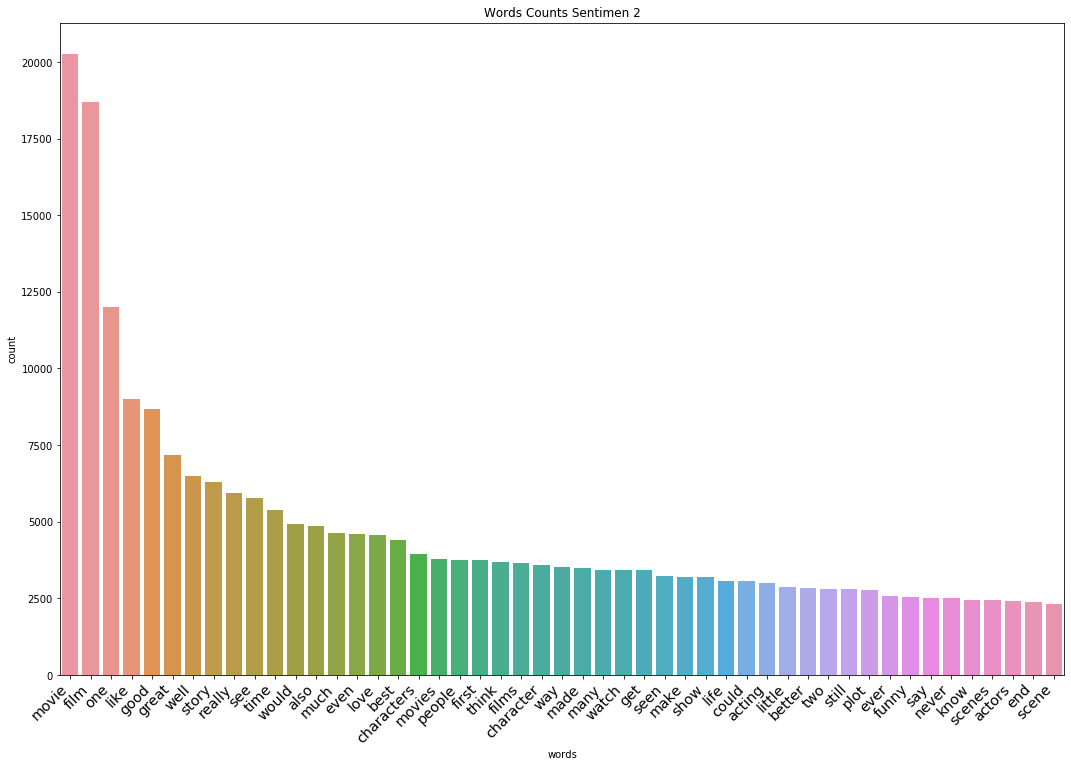

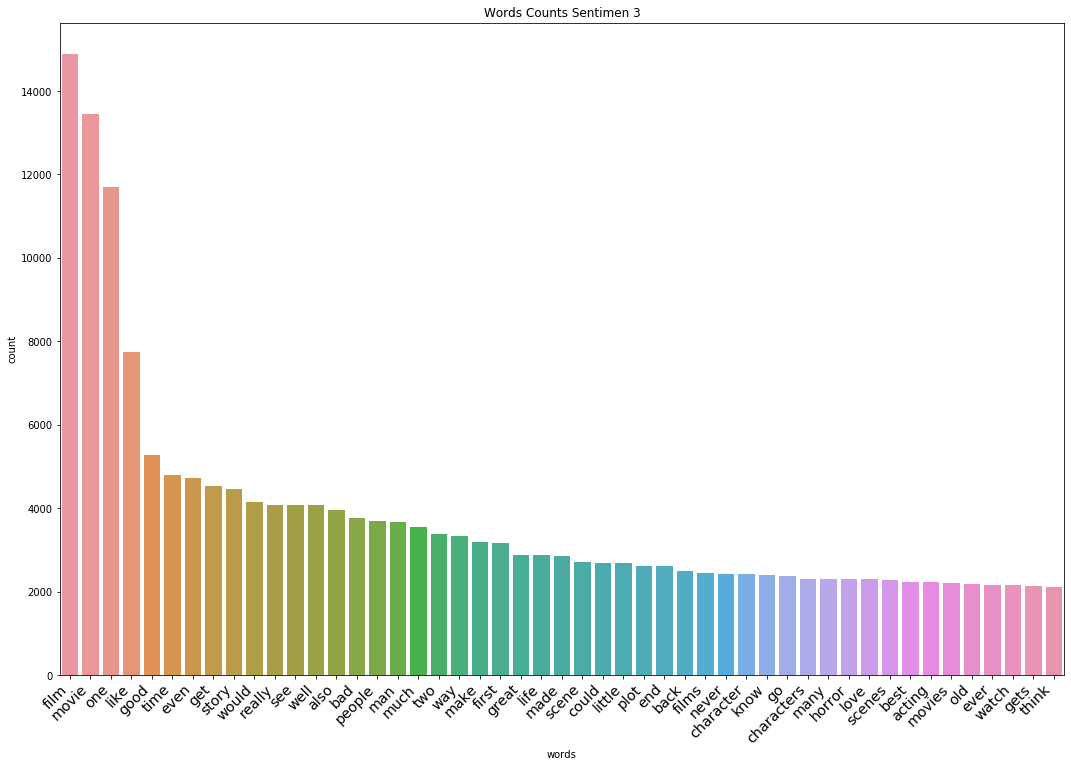

In [22]:
clusters_words_plot(texts=reviews_texts, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

### Visualize

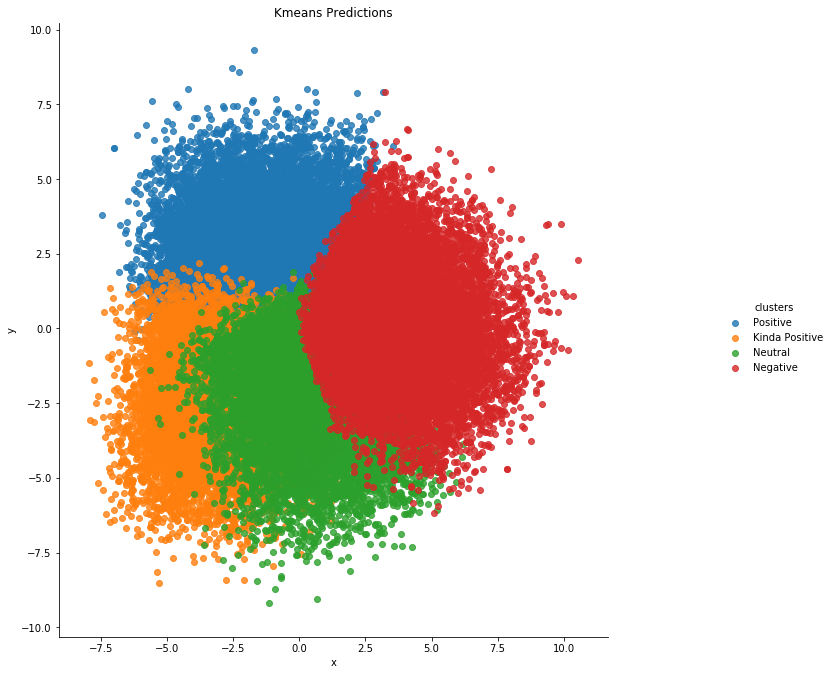

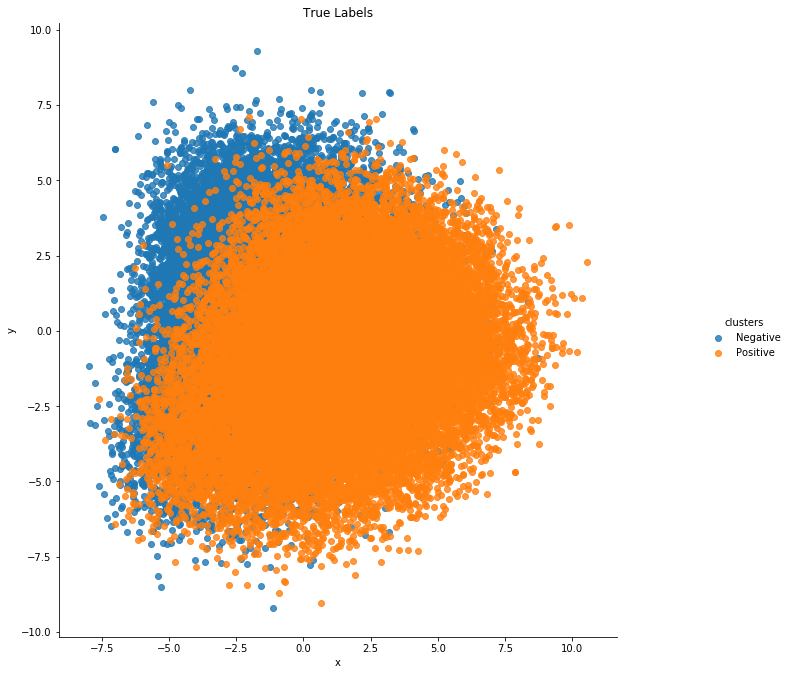

In [23]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative',
                       3:'Kinda Positive'}

reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [24]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=reviews_texts,
                        trues=reviews_sentiments, 
                        trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                        predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

Text  \
0  What more can be said? I have not been this fascinated with a young actress since Cate Blanchett burst upon the scene over ten years ago. And although both Blanchett and Blunt have played Queens now( seems to be the benchmark for up and coming actresses), the roles are complete polar opposites.<br /><br />Simply put if you are looking for high passion, compelling drama, and Machiavellian intrigue, this is not the movie for you. This isn't to say that the script or direction was bad, its just that the subject of the film did not lead too dramatic a life when compared to other notable royals like Elizabeth I, Anne Boylen, Henry VIII, Henry V, Henry II and Elainor of Acquitane. These are people whose lives were the stuff such as good soap operas are made of and whose policies and decisions altered the course of British ,and in most cases, world history. Victoria, in contrast, ascended the throne without incident, she quasi-governed a nation that was fast becoming a global power due to industrialization and the rise of the Navy, her State had a stable government led by competent and dynamic politicians, and she married young had a harmonious family life. The facts of her life are not the Sturm und Drag such as powerful dramas are made of.<br /><br />The heart of the film, aside from the attempt to dramatize her stultifying upbringing and the machinations surrounding her throne, is the story of the one thing that was truly shocking and surprising about her reign- a love story. Marriage made for financial or political reasons is with reason not necessarily the place to look for world shaking passion, yet Victoria will always be remembered in history as being sort of a Patron Saint marital fidelity, happiness and ideal family life. Thus, central to the film is the budding love of Victoria and her Prince Albert. I was very taken with Rupert Friend's characterization of Albert whom he portrayed as a kind, patient, somewhat earnest and maybe a touch naive young man, looking to" do good in the world and help". In short, he is a good man with a good heart, not the most dynamic figure to base a drama around, but as that is not the point of the story, that does not matter. The heart of the character shines through thanks to Friend's understated yet earnest performance. <br /><br />As for the Queen, well..Emily Blunt is sublime. Her beauty cannot be denied, but she is more than something pretty to look at; her face is like quicksilver because of her expressiveness. The slightest arch of the eyebrow, glance of the eye or slight wry smile delivers so much. Again, this is not a bombastic performance of heavy speeches and impassioned pleas, its not that kind of movie. But what Ms. Blunt does do with the role is show the simple humanity of the character with potent subtlety. <br /><br />For example, we see the joie de vivre that has been kept in check by Victoria's mother ( Miranda Richardson) and her scheming adviser/lover Conroy expressed in the simple things like Victoria trying to sketch her dog. We see her delight and fascination upon first meeting Albert by her eyes being continually drawn to him. We see her nervous and overwhelmed when addressing Parliament upon her Ascension. And my favorite scene of all in the film- we see her nervous, happy, and hopeful as she steels herself to do what really most women never have to do in their life- ask the man she loves to marry her, a proposition so ridiculous for those times( and some would say now) that Victoria bursts out in nervous laughter before she can even say "marry me". Again, this is not a movie for over the top larger than life expressions, but more a study in the subtleties of a character and making the little things say so much.<br /><br />So, overall, I judge the film by what it is and what it tried to do and as such I give it a 7. I felt that some of the politics could be better explained and that some very fine actors were wasted with little do and little character develo

# Custom Samples

In [25]:
custom_text = "This workshop roks!!"

encodings_texts = embedding_model.encode(sentences=[custom_text], 
                                          batch_size=1, 
                                          show_progress_bar=True)
encodings_texts = np.array(encodings_texts)
kmean_label = kmean_model.predict(tf.get_static_value(encodings_texts))[0]

print('Text: ',custom_text)
print('Sentiment: ', kmeans_id_sentiment[kmean_label])

Batches: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]

Text:  This workshop roks!!
Sentiment:  Negative
